## Build Model to Predict Yelp Average Star Rating using Business Features

### Import Necessary Packages & Modules

In [36]:
import pickle
import urllib 
import zipfile 
import requests
import numpy as np
import pandas as pd
import seaborn as sn
import pandasql as ps
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from functools import reduce

from scipy import sparse
from pprint import pprint 
from itertools import chain
from numpy import vectorize
from mlxtend.plotting import plot_decision_regions
from pandas.tools.plotting import scatter_matrix 

from sklearn.svm import SVR
from sklearn import metrics, neighbors, ensemble, datasets
from sklearn import neighbors
from sklearn.utils import shuffle
from sklearn.decomposition import PCA 
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge
from sklearn.model_selection import GridSearchCV,train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier, RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report, mean_squared_error, roc_curve

In [37]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  

## Load CSV
# This dataset has gone through EDA in a separate notebook & 
# went through feature engineering for ohe and to address missing value 

df = pd.read_csv("datasets/odyssey_features_updated.csv") 

## Remove unneeded columns
col_remove = ['address','categories','city','cuisine',
              'latitude','longitude','name','state',
              'cat','price_range_1','price_range_2',
              'price_range_3','price_range_4','postal_code',
              'neighborhood'
             ]

cat_columns = ['cat_Calgary_american_1.0', 'cat_Calgary_american_2.0', 'cat_Calgary_american_3.0',
               'cat_Calgary_american_4.0', 'cat_Calgary_american_nan', 'cat_Calgary_chinese_1.0',
               'cat_Calgary_chinese_2.0', 'cat_Calgary_chinese_3.0', 'cat_Calgary_chinese_nan',
               'cat_Calgary_italian_1.0', 'cat_Calgary_italian_2.0', 'cat_Calgary_italian_3.0',
               'cat_Calgary_italian_4.0', 'cat_Calgary_italian_nan', 'cat_Las Vegas_american_1.0',
               'cat_Las Vegas_american_2.0', 'cat_Las Vegas_american_3.0', 'cat_Las Vegas_american_4.0',
               'cat_Las Vegas_american_nan', 'cat_Las Vegas_chinese_1.0', 'cat_Las Vegas_chinese_2.0',
               'cat_Las Vegas_chinese_3.0', 'cat_Las Vegas_chinese_4.0', 'cat_Las Vegas_chinese_nan',
               'cat_Las Vegas_italian_1.0', 'cat_Las Vegas_italian_2.0', 'cat_Las Vegas_italian_3.0',
               'cat_Las Vegas_italian_4.0', 'cat_Las Vegas_italian_nan', 'cat_Toronto_american_1.0',
               'cat_Toronto_american_2.0', 'cat_Toronto_american_3.0', 'cat_Toronto_american_4.0',
               'cat_Toronto_american_nan', 'cat_Toronto_chinese_1.0', 'cat_Toronto_chinese_2.0',
               'cat_Toronto_chinese_3.0', 'cat_Toronto_chinese_4.0', 'cat_Toronto_chinese_nan',
               'cat_Toronto_italian_1.0', 'cat_Toronto_italian_2.0', 'cat_Toronto_italian_3.0',
               'cat_Toronto_italian_4.0', 'cat_Toronto_italian_nan'
              ]

yelp_df = df.drop(col_remove, axis=1)
temp_df = yelp_df.drop(cat_columns, axis = 1)
temp_list = list(temp_df)
yelp_df = yelp_df.drop_duplicates(temp_list)

## Set business_id as Index
yelp_df.set_index('business_id', inplace=True)

## Transform object type columns
obj_cols = list(yelp_df.select_dtypes(include = 'object').columns.values)

for col in obj_cols:
    yelp_df[col] = yelp_df[col].replace(np.NaN, -1.0)
    yelp_df[col] = yelp_df[col].replace(True, 1.0)
    yelp_df[col] = yelp_df[col].replace(False, 0.0)

yelp_df.drop_duplicates(inplace=True)
yelp_df.head(5)

,BikeParking,BusinessAcceptsCreditCards,Caters,CoatCheck,GoodForKids,HappyHour,HasTV,OutdoorSeating,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,review_count,cat_Calgary_american_1.0,cat_Calgary_american_2.0,cat_Calgary_american_3.0,cat_Calgary_american_4.0,cat_Calgary_american_nan,cat_Calgary_chinese_1.0,cat_Calgary_chinese_2.0,cat_Calgary_chinese_3.0,cat_Calgary_chinese_nan,cat_Calgary_italian_1.0,cat_Calgary_italian_2.0,cat_Calgary_italian_3.0,cat_Calgary_italian_4.0,cat_Calgary_italian_nan,cat_Las Vegas_american_1.0,cat_Las Vegas_american_2.0,cat_Las Vegas_american_3.0,cat_Las Vegas_american_4.0,cat_Las Vegas_american_nan,cat_Las Vegas_chinese_1.0,cat_Las Vegas_chinese_2.0,cat_Las Vegas_chinese_3.0,cat_Las Vegas_chinese_4.0,cat_Las Vegas_chinese_nan,cat_Las Vegas_italian_1.0,cat_Las Vegas_italian_2.0,cat_Las Vegas_italian_3.0,cat_Las Vegas_italian_4.0,cat_Las Vegas_italian_nan,cat_Toronto_american_1.0,cat_Toronto_american_2.0,cat_Toronto_american_3.0,cat_Toronto_american_4.0,cat_Toronto_american_nan,cat_Toronto_chinese_1.0,cat_Toronto_chinese_2.0,cat_Toronto_chinese_3.0,cat_Toronto_chinese_4.0,cat_Toronto_chinese_nan,cat_Toronto_italian_1.0,cat_Toronto_italian_2.0,cat_Toronto_italian_3.0,cat_Toronto_italian_4.0,cat_Toronto_italian_nan,negative_reviews,neutral_reviews,positive_reviews,stars,ambience_romantic,ambience_intimate,ambience_classy,ambience_hipster,ambience_touristy,ambience_trendy,ambience_upscale,ambience_casual,good_for_dessert,good_for_latenight,good_for_lunch,good_for_dinner,good_for_breakfast,good_for_brunch,parking_garage,parking_street,parking_validated,parking_lot,parking_valet,TotalOpenTimeInWeek,NumberOfWeekdaysWithEarlyOpening,NumberOfWeekdaysWithLateClosing,OpenOnWeekends,bestnight_monday,bestnight_tuesday,bestnight_wednesday,bestnight_thursday,bestnight_friday,bestnight_saturday,bestnight_sunday,music_dj,music_background_music,music_no_music,music_karaoke,music_live,music_video,music_jukebox,full_bar,beer_and_wine,no_alcohol,smoking_outdoor,smoking_no,smoking_yes,wifi_free,wifi_no,wifi_paid,noise_average,noise_loud,noise_quiet,noise_very_loud,attire_casual,attire_dressy
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
XeDLyY2a7nZ3IEY4RYslXA,1.0,1.0,0.0,-1.0,1.0,-1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63.0,49.0,334.0,3.587444,False,False,False,False,False,False,False,True,False,True,True,True,False,False,False,False,False,True,False,0.0,5.0,5.0,2.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,True,False
stbX9rtRIpDF-VymOwHJ8w,-1.0,1.0,-1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,11.5,7.0,11.5,0.0,12.0,8.0,11.0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.0,9.0,44.0,2.536232,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,True,False,61.0,0.0,4.0,0.0,False,True,True,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,True,False
Vn-Xqc1qkF1Vh2Z-wHkBVw,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,10.0,9.0,10.0,0.0,10.0,10.0,10.0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,20.0,4.619048,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,59.0,4.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False
xd-AnaGxEMKT2zTEheP6_w,

In [38]:
## Define function to split yelp_df into train & validation (unseen) sets.

def split_dataset(data, seed):
    
    dependent_var = 'stars'
    y = data[dependent_var]
    x = data.drop(dependent_var, axis = 1)
    x_train, x_val, y_train, y_val = train_test_split(x, y, 
                                                      test_size=0.3, 
                                                      random_state=seed)
    
    return x, y, x_train, x_val, y_train, y_val
#     x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=2)

In [39]:
## Define function to categorise average star-rating to 5 categories.

def rounder(x):
    
     if x>0 and x<1.5:
          return 1
     elif x>=1.5 and x<2.5:
          return 2
     elif x>=2.5 and x<3.5:
          return 3
     elif x>=3.5 and x<4.5:
          return 4
     else:
          return 5

vrounder = vectorize(rounder)

In [41]:
## Defining a Grid Search CV Function for Selected 

def model_CVGridSearch(model, param_grid, n_jobs, rs):

    if model == SVR:
        estimator = model()
    else:
        estimator = model(random_state = rs)
    cv = 9
    regressor = GridSearchCV(estimator=estimator, cv=cv,
                              param_grid=param_grid, n_jobs=n_jobs)
    regressor.fit(x_train, y_train)
    print("Best Estimator learned through GridSearch for " + str(model))
    print(regressor.best_estimator_)
    
    return cv, regressor.best_estimator_, regressor.best_params_, regressor.cv_results_

In [12]:
# Define function to add regression scoring to classification of 1-5

def scoring_plus(best_model, xx, yy):
    
    y_pred = best_model.predict(xx)
    yyy_pred = vrounder(y_pred)
    yy_train = yy.apply(rounder)
    
    id_list = list(yy_train.index.values)
    predc_df = pd.DataFrame(yyy_pred, dtype='str', index=id_list)
    yyy_pred = predc_df.apply(lambda x: ' '.join(x), axis=1)
    
    pred_df = pd.DataFrame(y_pred, dtype='str', index=id_list)
    yy_pred = pred_df.apply(lambda x: ' '.join(x), axis=1)
    
    yy_train = yy_train.astype('str')
    
    return yy_train, yyy_pred, yy_pred, y_pred

In [13]:
# Define function to compare performances of estimators

def performances(best_model):

    yy_train, yyy_predtrain, yy_predtrain, y_predtrain = scoring_plus(best_model, x_train,y_train)
    
    yy_val, yyy_predval, yy_predval, y_predval = scoring_plus(best_model, x_val,y_val)

    train_r2 = best_model.score(x_train,y_train)
    val_r2 = best_model.score(x_val,y_val)
    train_acc = str(accuracy_score(yy_train,yyy_predtrain))
    val_acc = str(accuracy_score(yy_val,yyy_predval))
    
    return train_r2, val_r2, train_acc, val_acc

In [14]:
# Function to Plot Training vs CV performances

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


### reference : https://github.com/shankarmsy/practice_GBRT/blob/master/Gradient%20Boosted%20Regression%20Trees%20with%20scikit-learn.ipynb

In [15]:
# Function to list down important features based on estimators

def see_importantfeatures(estimator,data):
    
    if estimator == ridge_best:
        nonzero_index = np.where(np.absolute(estimator.coef_) > 0.03)
    elif estimator == lasso_best:
        nonzero_index = np.where(estimator.coef_ != 0)
    else:
        nonzero_index = np.where(estimator.feature_importances_ != 0)
        
    nonzero_index = list(chain.from_iterable(nonzero_index))
    new_data = data.iloc[:, nonzero_index]
    pprint(list(new_data))
    print(len(new_data.columns))

In [16]:
# Function to filter dataframe based on top features 

def filter_feat(feat_ds, data, value):
    
    list_topfeat = feat_ds.ALL[(feat_ds['Total'] > value)]
    top_feat = list(list_topfeat.values)
    y_list = ['stars']
    new_data = data.loc[:, top_feat+y_list]
    
    return new_data

In [17]:
def change_type(pred,ids):
    
    id_list = list(ids.index.values)    
    pred = pd.DataFrame(pred, dtype='str', index=id_list).apply(lambda x: ' '.join(x), axis=1)
    
    return pred

In [28]:
## Final Predict Function. x is the input variable i.e. the table that contains all the predictors in pandas.core.frame.DataFrame.
# ids is the dataframe of dummy_id provided at each parse of prediction.

def avg_predict(x,ids):

    lasso_pred = lasso_best.predict(x)
    ridge_pred = ridge_best.predict(x)
    gbm_pred = gbm_best.predict(x)
    svr_pred = svr_best.predict(x)
    rf_pred = rf_best.predict(x)
      
    lasso_pred = change_type(lasso_pred,ids)
    ridge_pred = change_type(ridge_pred,ids)
    gbm_pred = change_type(gbm_pred,ids) 
    svr_pred = change_type(svr_pred,ids) 
    rf_pred = change_type(rf_pred,ids)     
        
    lasso_pred = lasso_pred.to_frame()
    ridge_pred = ridge_pred.to_frame()
    gbm_pred = gbm_pred.to_frame()
    svr_pred = svr_pred.to_frame()
    rf_pred = rf_pred.to_frame()
    
    dfs = [lasso_pred, ridge_pred,gbm_pred,svr_pred,rf_pred]
    all_pred = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)

    all_pred.columns.values[0] = "lasso_pred"
    all_pred.columns.values[1] = "ridge_pred"
    all_pred.columns.values[2] = "gbm_pred"
    all_pred.columns.values[3] = "svr_pred"
    all_pred.columns.values[4] = "rf_pred"

    all_pred['lasso_pred'] = all_pred['lasso_pred'].astype(float).fillna(0.0)
    all_pred['ridge_pred'] = all_pred['ridge_pred'].astype(float).fillna(0.0)
    all_pred['gbm_pred'] = all_pred['gbm_pred'].astype(float).fillna(0.0)
    all_pred['svr_pred'] = all_pred['svr_pred'].astype(float).fillna(0.0)
    all_pred['rf_pred'] = all_pred['rf_pred'].astype(float).fillna(0.0)

    all_pred['pred'] = all_pred.apply(lambda row: 0.2*row['lasso_pred'] + 
                                      0.2*row['ridge_pred'] + 0.15*row['gbm_pred'] + 
                                      0.4*row['svr_pred'] + 0.05*row['rf_pred'], axis=1)
    
    avg_pred = all_pred['pred']
    avg_pred = avg_pred.to_frame()
    
    return avg_pred

In [44]:
# Set Parameters to be Tuned, for each Estimator

seed = 29
lasso_param = [{'alpha': np.logspace(-4, -0.5, 30)}]
lasso_jobs = 3
lasso_rs = seed

ridge_param = [{'alpha': np.linspace(0.0001, 2.0, 100)}]
ridge_jobs = 4
ridge_rs = seed

gbm_param = {'n_estimators':[100,200],
          'learning_rate': [0.1, 0.05, 0.02, 0.01],
          'max_depth':[6,4,3],
          'min_samples_leaf':[3,5,9,17],
          'max_features':[1.0,0.3,0.1]
         }
gbm_jobs = 4
gbm_rs = seed

svr_param = {'degree':[1,2,3],
             'C':[1.5, 10],
             'gamma': [1e-7, 1e-4],
             'epsilon':[0.1,0.2,0.5,0.3]
            }
svr_jobs = 4
svr_rs = seed

rf_param = {'n_estimators': [10,50],
            'max_features': ['auto', 'sqrt', 'log2'],
            'criterion' :['mse']
           }
rf_jobs = 4
rf_rs = seed


In [45]:
%%time

## Build multiple estimators on Yelp Dataset

x, y, x_train, x_val, y_train, y_val = split_dataset(yelp_df, 123)

lasso_cv, lasso_best, lasso_params, lasso_cvResults = model_CVGridSearch(
    Lasso, lasso_param, lasso_jobs, lasso_rs)
print("------------------------------------------------------------------------------------------------------------")
ridge_cv, ridge_best, ridge_params, ridge_cvResults = model_CVGridSearch(
    Ridge, ridge_param, ridge_jobs, ridge_rs)
print("------------------------------------------------------------------------------------------------------------")
gbm_cv, gbm_best, gbm_params, gbm_cvResults = model_CVGridSearch(
    GradientBoostingRegressor, gbm_param, gbm_jobs, gbm_rs)
print("------------------------------------------------------------------------------------------------------------")
svr_cv, svr_best, svr_params, svr_cvResults = model_CVGridSearch(
    SVR, svr_param, svr_jobs, svr_rs)
print("------------------------------------------------------------------------------------------------------------")
rf_cv, rf_best, rf_params, rf_cvResults = model_CVGridSearch(
    RandomForestRegressor, rf_param, rf_jobs, rf_rs)

Best Estimator learned through GridSearch for <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Lasso(alpha=0.0012195704601594415, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=29, selection='cyclic', tol=0.0001, warm_start=False)
------------------------------------------------------------------------------------------------------------
Best Estimator learned through GridSearch for <class 'sklearn.linear_model.ridge.Ridge'>
Ridge(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='auto', tol=0.001)
------------------------------------------------------------------------------------------------------------
Best Estimator learned through GridSearch for <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_featu

In [46]:
# Compare Performance for Estimators

l_t_r2, l_v_r2, l_t_acc, l_v_acc = performances(lasso_best)
r_t_r2, r_v_r2, r_t_acc, r_v_acc = performances(ridge_best)
g_t_r2, g_v_r2, g_t_acc, g_v_acc = performances(gbm_best)
s_t_r2, s_v_r2, s_t_acc, s_v_acc = performances(svr_best)
rf_t_r2, rf_v_r2, rf_t_acc, rf_v_acc = performances(rf_best)

model_comparison = pd.DataFrame({'model': ['Lasso', 'Ridge', 'GBM','SVR', 'RF'], 
                                 'train_r2':  [l_t_r2, r_t_r2, g_t_r2,s_t_r2,rf_t_r2],
                                 'val_r2': [l_v_r2, r_v_r2, g_v_r2,s_v_r2,rf_v_r2],
                                 'train_accuracy': [l_t_acc, r_t_acc, g_t_acc,s_t_acc,rf_t_acc],
                                 'val_accuracy': [l_v_acc, r_v_acc, g_v_acc,s_v_acc,rf_v_acc]    
                                })

# Order the dataframe
model_comparison = model_comparison[['model', 'train_r2', 'val_r2', 'train_accuracy','val_accuracy']]

print("Model Performances' Comparison")
model_comparison

Model Performances' Comparison


,model,train_r2,val_r2,train_accuracy,val_accuracy
0,Lasso,0.277426,0.248221,0.5776683087027915,0.5616858237547893
1,Ridge,0.290973,0.239761,0.5783251231527093,0.5601532567049808
2,GBM,0.756382,0.687848,0.7494252873563219,0.7003831417624521
3,SVR,0.655755,0.625387,0.7103448275862069,0.6919540229885057
4,RF,0.945666,0.650444,0.8738916256157635,0.6919540229885057


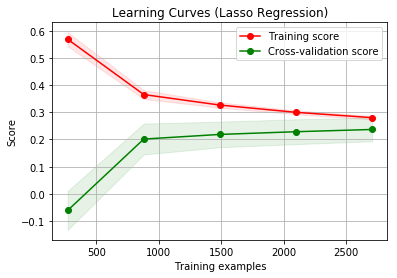

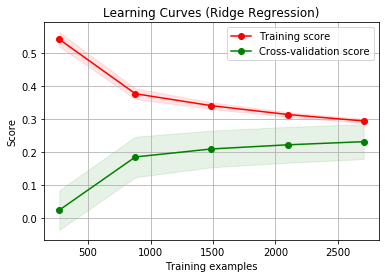

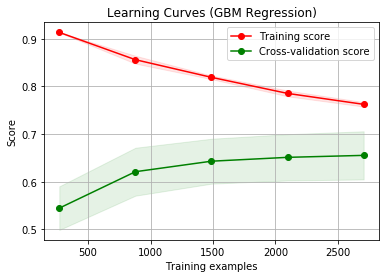

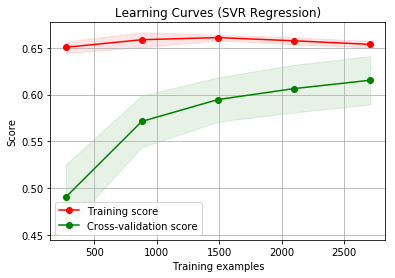

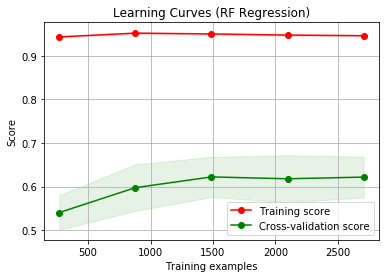

In [47]:
## Plot Training and CV Scores for each Estimator

title1 = "Learning Curves (Lasso Regression)" 
plot_learning_curve(lasso_best, title1, x_train, y_train, cv=lasso_cv, n_jobs=lasso_jobs)

title2 = "Learning Curves (Ridge Regression)" 
plot_learning_curve(ridge_best, title2, x_train, y_train, cv=ridge_cv, n_jobs=ridge_jobs)

title3 = "Learning Curves (GBM Regression)" 
plot_learning_curve(gbm_best, title3, x_train, y_train, cv=gbm_cv, n_jobs=gbm_jobs)

title4 = "Learning Curves (SVR Regression)" 
plot_learning_curve(svr_best, title4, x_train, y_train, cv=svr_cv, n_jobs=svr_jobs)

title5 = "Learning Curves (RF Regression)" 
plot_learning_curve(rf_best, title6, x_train, y_train, cv=rf_cv, n_jobs=rf_jobs)

plt.show()

In [ ]:
## We can see that linear models produces a lower range of train & validation R-Squared 
## compared to the non-linear estimators. Similarly, as we classify the predictions and 
## actual labels into star-rating groups between 1 to 5, accuracy of the prediction produces the same. 
## SVR estimator shows the most stable and a relatively good performance.
## There could be slight overfitting seen on the tree based estimators, although 
## they generally have higher R-Squared and accuracy. The other models shows stability 
## albeit lower R-Squared and accuracy.

## We shall now try to reduce number of features used, to try to get a more stable model.

## Analyse Top/Significant Features on applicable models.

In [24]:
## Export Coefficients & Feature Importances to be manually analysed

pd.Series(lasso_best.coef_, index=x.columns).to_csv('models/lasso_imp.csv')
pd.Series(ridge_best.coef_, index=x.columns).to_csv('models/ridge_imp.csv')
pd.Series(gbm_best.feature_importances_, index=x.columns).to_csv('models/gbm_imp.csv')
pd.Series(rf_best.feature_importances_, index=x.columns).to_csv('models/rf_imp.csv')

In [30]:
## Import Analysis of Feature Importance & Filter Dataset

feat_df = pd.read_csv('models/analyse_important_features.csv')

## Filter features based on importance

yelp_df2 = filter_feat(feat_df,yelp_df,0.039) # increase value to reduce features.

### Rebuild estimators using filtered features

In [49]:
%%time

## Build multiple estimators on Yelp Dataset with less features.

x, y, x_train, x_val, y_train, y_val = split_dataset(yelp_df2, 120)

lasso_cv2, lasso_best2, lasso_params2, lasso_cvResults2 = model_CVGridSearch(
    Lasso, lasso_param, lasso_jobs, lasso_rs)
print("------------------------------------------------------------------------------------------------------------")
ridge_cv2, ridge_best2, ridge_params2, ridge_cvResults2 = model_CVGridSearch(
    Ridge, ridge_param, ridge_jobs, ridge_rs)
print("------------------------------------------------------------------------------------------------------------")
gbm_cv2, gbm_best2, gbm_params2, gbm_cvResults2 = model_CVGridSearch(
    GradientBoostingRegressor, gbm_param, gbm_jobs, gbm_rs)
print("------------------------------------------------------------------------------------------------------------")
svr_cv2, svr_best2, svr_params2, svr_cvResults2 = model_CVGridSearch(
    SVR, svr_param, svr_jobs, svr_rs)
print("------------------------------------------------------------------------------------------------------------")
rf_cv2, rf_best2, rf_params2, rf_cvResults2 = model_CVGridSearch(
    RandomForestRegressor, rf_param, rf_jobs, rf_rs)

Best Estimator learned through GridSearch for <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Lasso(alpha=0.0012195704601594415, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=29, selection='cyclic', tol=0.0001, warm_start=False)
------------------------------------------------------------------------------------------------------------
Best Estimator learned through GridSearch for <class 'sklearn.linear_model.ridge.Ridge'>
Ridge(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='auto', tol=0.001)
------------------------------------------------------------------------------------------------------------
Best Estimator learned through GridSearch for <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_featu

In [50]:
## Compare Estimators' Performances with filtered features

l_t_r2, l_v_r2, l_t_acc, l_v_acc = performances(lasso_best2)
r_t_r2, r_v_r2, r_t_acc, r_v_acc = performances(ridge_best2)
g_t_r2, g_v_r2, g_t_acc, g_v_acc = performances(gbm_best2)
s_t_r2, s_v_r2, s_t_acc, s_v_acc = performances(svr_best2)
rf_t_r2, rf_v_r2, rf_t_acc, rf_v_acc = performances(rf_best2)

model_comparison = pd.DataFrame({'model': ['Lasso', 'Ridge', 'GBM','SVR', 'RF'], 
                                 'train_r2':  [l_t_r2, r_t_r2, g_t_r2,s_t_r2,rf_t_r2],
                                 'val_r2': [l_v_r2, r_v_r2, g_v_r2,s_v_r2,rf_v_r2],
                                 'train_accuracy': [l_t_acc, r_t_acc, g_t_acc,s_t_acc,rf_t_acc],
                                 'val_accuracy': [l_v_acc, r_v_acc, g_v_acc,s_v_acc,rf_v_acc]    
                                })

# Order the dataframe
model_comparison = model_comparison[['model', 'train_r2', 'val_r2', 'train_accuracy','val_accuracy']]

print("Model Performances' Comparison - Filtered Features")
model_comparison

Model Performances' Comparison - Filtered Features


,model,train_r2,val_r2,train_accuracy,val_accuracy
0,Lasso,0.285660,0.224816,0.5727422003284073,0.5524904214559387
1,Ridge,0.296779,0.224872,0.5766830870279146,0.5578544061302682
2,GBM,0.757760,0.646974,0.7477832512315271,0.6919540229885057
3,SVR,0.657296,0.587700,0.7110016420361248,0.6620689655172414
4,RF,0.949653,0.603736,0.8807881773399014,0.6804597701149425


In [471]:
## Reducing features doesn't show much changes (slightly more potential to overfitting) 
## in the performances of the model. 
## Additionally, since these features aer useful for users to input in the dashboard,
## it is still worthwhile to remain all of the features.

In [52]:
## Let's now run an ensemble of the 6 estimators, using all available features.
## The ensembling method used is taking weighted average, with more weight given to SVR,
## and lesser weight given to tree models, to counter overfitting, and to add more 
## stability.

x, y, x_train, x_val, y_train, y_val = split_dataset(yelp_df, 123)

# Run Prediction Ensemble on Train & Validation datasets
avg_predt = avg_predict(x_train,y_train)
avg_predv = avg_predict(x_val,y_val)

# Check R-Squared of Train & Validation sets
r2_train = r2_score(y_train,avg_predt)
r2_val = r2_score(y_val,avg_predv)

# Check accuracy of Train & Validation sets
avg_predtc = vrounder(avg_predt)
yy_train = y_train.apply(rounder)
id_list = list(yy_train.index.values)
predc_df = pd.DataFrame(avg_predtc, dtype='str', index=id_list)
avg_predtc = predc_df.apply(lambda x: ' '.join(x), axis=1)
yy_train = yy_train.astype('str')
acc_train = accuracy_score(yy_train,avg_predtc)

avg_predvc = vrounder(avg_predv)
yy_val = y_val.apply(rounder)
id_list = list(yy_val.index.values)
predc_df = pd.DataFrame(avg_predvc, dtype='str', index=id_list)
avg_predvc = predc_df.apply(lambda x: ' '.join(x), axis=1)
yy_val = yy_val.astype('str')
acc_val = accuracy_score(yy_val,avg_predvc)

# Print results
model_comparison = pd.DataFrame({'model': 'Ensembled_Model', 
                                 'train_r2':  [r2_train],
                                 'val_r2': [r2_val],
                                 'train_accuracy': [acc_train],
                                 'val_accuracy': [acc_val]    
                                })

# Order the dataframe
model_comparison = model_comparison[['model', 'train_r2', 'val_r2', 'train_accuracy','val_accuracy']]

print("Model Performance For Ensembled Model")
model_comparison


Model Performance For Ensembled Model


,model,train_r2,val_r2,train_accuracy,val_accuracy
0,Ensembled_Model,0.637443,0.591404,0.705747,0.678161


In [ ]:
## Ensembled Performance shows reasonable stability and accuracy
## for R-Squared and classification accuracy scoring.
## We shall proceed in using this ensemble model as 
## the final model for this project.

In [53]:
## Re-fit model using all datasets (without splitting train & validation):

lasso_best.fit(x,y)
ridge_best.fit(x,y)
gbm_best.fit(x,y)
svr_best.fit(x,y)
rf_best.fit(x,y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=29, verbose=0, warm_start=False)

In [27]:
## List of Features

list(yelp_df)

['BikeParking',
 'BusinessAcceptsCreditCards',
 'Caters',
 'CoatCheck',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'OutdoorSeating',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WheelchairAccessible',
 'Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'review_count',
 'cat_Calgary_american_1.0',
 'cat_Calgary_american_2.0',
 'cat_Calgary_american_3.0',
 'cat_Calgary_american_4.0',
 'cat_Calgary_american_nan',
 'cat_Calgary_chinese_1.0',
 'cat_Calgary_chinese_2.0',
 'cat_Calgary_chinese_3.0',
 'cat_Calgary_chinese_nan',
 'cat_Calgary_italian_1.0',
 'cat_Calgary_italian_2.0',
 'cat_Calgary_italian_3.0',
 'cat_Calgary_italian_4.0',
 'cat_Calgary_italian_nan',
 'cat_Las Vegas_american_1.0',
 'cat_Las Vegas_american_2.0',
 'cat_Las Vegas_american_3.0',
 'cat_Las Vegas_american_4.0',
 'cat_Las Vegas_american_nan',
 'cat_Las Vegas_chinese_1.0',
 'cat_Las Vegas_chinese_2.0'

In [54]:
## Save models 

lasso = 'models/lasso_model.sav'
pickle.dump(lasso_best, open(lasso, 'wb'))

ridge = 'models/ridge_model.sav'
pickle.dump(ridge_best, open(ridge, 'wb'))

gbm = 'models/gbm_model.sav'
pickle.dump(gbm_best, open(gbm, 'wb'))

svr = 'models/svr_model.sav'
pickle.dump(svr_best, open(svr, 'wb'))

rf = 'models/rf_model.sav'
pickle.dump(rf_best, open(rf, 'wb'))
